# NBA Salary Final Project

## Data

- NBA Database containing collection of data from 1937 - 2011
    - https://relational.fit.cvut.cz/dataset/NBA
    - Data from this source will be loaded into a SQL instance and queried accordingly
- NBA Player Salaries from 1990 - 2018
    - https://data.world/datadavis/nba-salaries/workspace/file?filename=nba_salaries_1990_to_2018.csv
    - Salaries for each individual player for each year of their career
    - CSV Data will be uploaded to a pandas dataframe 
- NBA Team Salary Cap History
    - http://www.celticshub.com/2017/12/07/nba-player-salaries-1991-2017/
    - Salary caps for each team each year they were active.
    - Data will downloaded as a CSV file from google sheets and then uploaded to a pandas dataframe
- NBA Player Stats Since 1950
    - https://www.kaggle.com/drgilermo/nba-players-stats#Seasons_Stats.csv
    - Historical statistics for all NBA players from 1950-2017.
    - Data will be downloaded as a csv then uploaded to a MySQL instance (database). This database will then be accessed through python and uploaded to a pandas dataframe. From there it will then be integrated with the Player salary data.

a note about the data used. originally the plan was to use Data from the Basektball database found online, by accessing the data through MySQL. I ran into problems while trying to access the database from Python do to permission difficulties. As a solution I downloaded the data from the Database through MySQL as a csv file. I then created a new database through MySQL and uploaded the data to this new database which I would be able to access through python.

## Questions

***
- Which players do teams spend the most of their salary cap on?
   
- Do the player's performance justify their salary?
    
- Where do the highest paid player for each team land in the rankings of the highest paid players of the league?
   
- If there is a discrepancy between the highest paid player for a team in comparison to the league, how does their performance match up to those that are being paid more?

## Approach

***
- The data from the NBA database will be accessed using MySQL. 
- The data will then be transferred via python to a pandas data frame.
- The NBA Salary data will be imported into python as a CSV
- All of the imported data will then be cleaned
    - the Salary cap data will also need to be transformed from wide format to long format
    - Players will then be grouped by year, team, salary or year, team, performance rating and ordered according to each for each year
    - Teams will also be grouped by years and then ordered by salary caps
- A new variable will be created for player's salary share, which will be created by dividing the team salary cap for a specific year, by the players salary for that year
    - This will be done for each team separately
- Bar plots will then be constructed for the highest paid players and teams with the highest cap
- Scatter plot displaying player salaries and player efficiency rating
    - Is there a relationship between how much a player makes and how well they play?

In [5]:
import os
import pymysql
import pandas as pd
import sqlalchemy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import seaborn as sns


### NBA Stats 

In [6]:
engine = sqlalchemy.create_engine('mysql+pymysql://root:@localhost:3306/NBA')

In [7]:
NBA_stats = pd.read_sql_table('SEASONS_STATS',engine, coerce_float = True)

In [8]:
NBA_stats.head()

,INDEX,YEAR,PLAYER,POS,AGE,TM,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,14470,2000,Tariq Abdul-Wahad,SG,25,TOT,61,56,1578,14.0,...,1.0,101,190,291,98,59,28,106,147,697
1,14471,2000,Tariq Abdul-Wahad,SG,25,ORL,46,46,1205,14.0,...,1.0,77,162,239,72,53,16,87,116,563
2,14472,2000,Tariq Abdul-Wahad,SG,25,DEN,15,10,373,11.0,...,1.0,24,28,52,26,6,12,19,31,134
3,14473,2000,Shareef Abdur-Rahim,SF,23,VAN,82,82,3223,20.0,...,1.0,218,607,825,271,89,87,249,244,1663
4,14474,2000,Cory Alexander,PG,26,DEN,29,2,329,9.0,...,1.0,8,34,42,58,24,2,28,39,82


#### Data Cleaning: NBA stats

In [9]:
NBA_stats.columns = ['Index','Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2', 'OBPM', 'DBPM',
       'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS']

In [10]:
# drop index column
NBA_stats = NBA_stats.drop('Index', axis = 1)
# rename 'Tm' column to 'Team'
NBA_stats.rename(columns = {'Tm': 'Team'}, inplace = True)

In [11]:
#When access to sql database is not availible use csv link bellow
#NBA_stats = pd.read_csv("https://raw.githubusercontent.com/AVIMARCUS6/DAV-5400/master/Final%20Project%20Data/Seasons_Stats.csv").drop(['Unnamed: 0'],axis=1)
NBA_16 = NBA_stats.loc[NBA_stats['Year'] == 2016]
NBA_16 = NBA_16.astype({'Year' : int, 'Age' : int, 'G' : int, 'GS' : int, 'MP' : int})
NBA_16.head()

,Year,Player,Pos,Age,Team,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
9031,2016,Quincy Acy,PF,25,SAC,59,29,876,15.0,1.0,...,1.0,65,123,188,27,29,24,27,103,307
9032,2016,Jordan Adams,SG,21,MEM,2,0,15,17.0,0.0,...,1.0,0,2,2,3,3,0,2,2,7
9033,2016,Steven Adams,C,22,OKC,80,80,2014,16.0,1.0,...,1.0,219,314,533,62,42,89,84,223,636
9034,2016,Arron Afflalo,SG,30,NYK,71,57,2371,11.0,1.0,...,1.0,23,243,266,144,25,10,82,142,909
9035,2016,Alexis Ajinca,C,27,NOP,59,17,861,14.0,1.0,...,1.0,75,194,269,31,19,36,54,134,352


In [12]:
list(NBA_16.columns)

['Year',
 'Player',
 'Pos',
 'Age',
 'Team',
 'G',
 'GS',
 'MP',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'TRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'blanl',
 'OWS',
 'DWS',
 'WS',
 'WS/48',
 'blank2',
 'OBPM',
 'DBPM',
 'BPM',
 'VORP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS']

In [13]:
NBA_16.shape

(578, 52)

***

In [14]:
NBA_16['Team'].unique()

array(['SAC', 'MEM', 'OKC', 'NYK', 'NOP', 'LAC', 'SAS', 'POR', 'IND',
       'TOT', 'MIA', 'WAS', 'DAL', 'MIL', 'DET', 'ORL', 'HOU', 'DEN',
       'CHI', 'GSW', 'BRK', 'LAL', 'CHO', 'ATL', 'TOR', 'MIN', 'PHO',
       'UTA', 'BOS', 'PHI', 'CLE'], dtype=object)

In [15]:
# Create new dataframe specifically for renaming team abreviations
NBA_team = NBA_16[['Player', 'Team']]

In [16]:
NBA_team = NBA_team.replace({'Team' : {'SAC':'Sacramento Kings',
                            'MEM': 'Memphis Grizzlies',
                            'NYK': 'New York Knicks', 
                            'NOP': 'New Orleans Pelicans',
                            'SAS': 'San Antonio Spures', 
                            'POR': 'Portland Trail Blazers', 
                            'TOT': 'Total', 
                            'MIA': 'Miami Heat', 
                            'WAS': 'Washington Wizards',
                            'DAL': 'Dallas Mavericks', 
                            'MIL':'Milwaukee Bucks', 
                            'ORL': 'Orlando Magic', 
                            'HOU': 'Houston Rockets', 
                            'DEN': 'Denver Nuggets', 
                            'OKC': 'Oklahoma City Thunder', 
                            'LAC': 'Los Angeles Clippers', 
                            'CHI': 'Chicago Bulls', 
                            'GSW': 'Golden State Warriors',
                            'BRK': 'Brooklyn Nets', 
                            'LAL': 'Los Angeles Lakers', 
                            'CHO': 'Charlotte Hornets', 
                            'DET': 'Detroit Pistons', 
                            'ATL': 'Atlanta Hawks', 
                            'TOR': 'Toronto Raptors', 
                            'MIN': 'Minnesota Timberwolves', 
                            'PHO': 'Phoenix Suns',  
                            'UTA': 'Utah Jazz',
                            'BOS': 'Boston Celtics', 
                            'PHI': 'Philadelphia 76ers', 
                            'IND': 'Indiana Pacers', 
                            'CLE': 'Cleveland Cavaliers'}})

In [17]:
#df = df[df.line_race != 0]
NBA_team = NBA_team[NBA_team.Team != 'Total']
list(NBA_team['Team'].unique())

['Sacramento Kings',
 'Memphis Grizzlies',
 'Oklahoma City Thunder',
 'New York Knicks',
 'New Orleans Pelicans',
 'Los Angeles Clippers',
 'San Antonio Spures',
 'Portland Trail Blazers',
 'Indiana Pacers',
 'Miami Heat',
 'Washington Wizards',
 'Dallas Mavericks',
 'Milwaukee Bucks',
 'Detroit Pistons',
 'Orlando Magic',
 'Houston Rockets',
 'Denver Nuggets',
 'Chicago Bulls',
 'Golden State Warriors',
 'Brooklyn Nets',
 'Los Angeles Lakers',
 'Charlotte Hornets',
 'Atlanta Hawks',
 'Toronto Raptors',
 'Minnesota Timberwolves',
 'Phoenix Suns',
 'Utah Jazz',
 'Boston Celtics',
 'Philadelphia 76ers',
 'Cleveland Cavaliers']

In [18]:
NBA_team.dtypes

Player    object
Team      object
dtype: object

In [19]:
NBA_team.head()

,Player,Team
9031,Quincy Acy,Sacramento Kings
9032,Jordan Adams,Memphis Grizzlies
9033,Steven Adams,Oklahoma City Thunder
9034,Arron Afflalo,New York Knicks
9035,Alexis Ajinca,New Orleans Pelicans


***

In [20]:
# create dataframe of just player and position
NBA_pos = NBA_16[['Player', 'Pos']]

***

#### The NBA stats data has duplicates of players. This is a result of players being traded during the season, hence they have statistical records for each of the teams they played on. These duplicates will have to be combined appropriatly using sum and average of each column to resolve this issue. In order to start this process the columns needed to be divided into to groups, those that should be averaged (Age, PER, etc.) and those that should be summed (Games played, Games started, etc.).

In [21]:
# dataframe containing all data that can be grouped and then AVG
NBA_16_AVG = NBA_16.groupby(['Player'])[['Year', 'Age', 'PER', 'TS%',  'USG%','WS', 'BPM', 'eFG%']].mean().round(2)
NBA_16_AVG['Year'] = NBA_16_AVG['Year'].astype({'Year' : int})
NBA_16_AVG.shape, NBA_16_AVG.head(),NBA_16_AVG.tail()


((476, 8),                 Year  Age   PER  TS%  USG%   WS  BPM  eFG%
 Player                                                    
 Aaron Brooks    2016   31  12.0  0.0  23.0  1.0 -3.0   0.0
 Aaron Gordon    2016   20  17.0  1.0  17.0  5.0  2.0   1.0
 Aaron Harrison  2016   21   4.0  0.0  14.0  0.0 -6.0   0.0
 Adreian Payne   2016   24   6.0  0.0  18.0 -1.0 -6.0   0.0
 Al Horford      2016   29  19.0  1.0  21.0  9.0  4.0   1.0,                 Year  Age   PER  TS%  USG%   WS  BPM  eFG%
 Player                                                    
 Willie Reed     2016   25  19.0  1.0  18.0  1.0 -2.0   1.0
 Xavier Munford  2016   23  10.0  0.0  18.0  0.0 -3.0   0.0
 Zach LaVine     2016   20  14.0  1.0  24.0  3.0 -1.0   1.0
 Zach Randolph   2016   34  18.0  1.0  25.0  4.0 -1.0   0.0
 Zaza Pachulia   2016   31  16.0  1.0  16.0  6.0  1.0   0.0)

In [22]:
# dataframe containing all data that can be grouped and summed
NBA_16_SUM = NBA_16.groupby(['Player'])[['G','GS', 'MP','TRB', 'AST', 'STL', 'BLK', 'PTS']].sum().round()
NBA_16_SUM.shape, NBA_16_SUM.head(),NBA_16_SUM.tail()

((476, 8),                  G  GS    MP  TRB  AST  STL  BLK   PTS
 Player                                                
 Aaron Brooks    69   0  1108  101  180   30   10   491
 Aaron Gordon    78  37  1863  507  128   59   55   719
 Aaron Harrison  21   0    93   15    2    6    0    18
 Adreian Payne   52   2   486  111   29   16   11   132
 Al Horford      82  82  2631  596  263   68  121  1249,                  G  GS    MP  TRB  AST  STL  BLK   PTS
 Player                                                
 Willie Reed     39   2   426  122   10    6   30   182
 Xavier Munford  14   0   244   31   22   13    3    80
 Zach LaVine     82  33  2294  228  251   69   17  1150
 Zach Randolph   68  53  2016  529  142   43   13  1040
 Zaza Pachulia   76  69  2004  718  128   64   22   650)

Now there are two seperate dataframes grouped by player containing the appropriate columns and calculations. It is also important to note that each dataframe has the same number of rows and Players are stored in the same order in each, this is important for when we concat the two dataframes

In [23]:
# concat the sum dataframe on the average dataframe
NBA_16 = pd.concat([NBA_16_AVG, NBA_16_SUM],axis=1)
NBA_16.head()

,Year,Age,PER,TS%,USG%,WS,BPM,eFG%,G,GS,MP,TRB,AST,STL,BLK,PTS
Player,,,,,,,,,,,,,,,,
Aaron Brooks,2016,31,12.0,0.0,23.0,1.0,-3.0,0.0,69,0,1108,101,180,30,10,491
Aaron Gordon,2016,20,17.0,1.0,17.0,5.0,2.0,1.0,78,37,1863,507,128,59,55,719
Aaron Harrison,2016,21,4.0,0.0,14.0,0.0,-6.0,0.0,21,0,93,15,2,6,0,18
Adreian Payne,2016,24,6.0,0.0,18.0,-1.0,-6.0,0.0,52,2,486,111,29,16,11,132
Al Horford,2016,29,19.0,1.0,21.0,9.0,4.0,1.0,82,82,2631,596,263,68,121,1249


In [24]:
# merge the Team and position dataframe on the new NBA_16 dataframe
NBA_16 = pd.merge(NBA_16, NBA_team, on="Player")
NBA_16.head()

,Player,Year,Age,PER,TS%,USG%,WS,BPM,eFG%,G,GS,MP,TRB,AST,STL,BLK,PTS,Team
0,Aaron Brooks,2016,31,12.0,0.0,23.0,1.0,-3.0,0.0,69,0,1108,101,180,30,10,491,Chicago Bulls
1,Aaron Gordon,2016,20,17.0,1.0,17.0,5.0,2.0,1.0,78,37,1863,507,128,59,55,719,Orlando Magic
2,Aaron Harrison,2016,21,4.0,0.0,14.0,0.0,-6.0,0.0,21,0,93,15,2,6,0,18,Charlotte Hornets
3,Adreian Payne,2016,24,6.0,0.0,18.0,-1.0,-6.0,0.0,52,2,486,111,29,16,11,132,Minnesota Timberwolves
4,Al Horford,2016,29,19.0,1.0,21.0,9.0,4.0,1.0,82,82,2631,596,263,68,121,1249,Atlanta Hawks


In [25]:
NBA_16 = pd.merge(NBA_16, NBA_pos, on="Player")
NBA_16.drop_duplicates().shape

(536, 19)

In [26]:
# group new dataframe and round to the 100th place
NBA_16 = NBA_16.groupby(['Year','Team','Player','Pos']).mean().round(4)

In [27]:
NBA_16.shape

(536, 15)

### NBA Player Salaries

Each player in the NBA recieves a salary based on their contract. A players contract is meant to represent their worth to the team they play for. Hence a player who has proven their importance through their playing should be paid more then a player who has not

In [28]:
sal_his = pd.read_csv("https://raw.githubusercontent.com/AVIMARCUS6/DAV-5400/master/Final%20Project%20Data/NBA_Salary_History%20-%20HistoryFormatted.csv")

In [29]:
sal_his.columns

Index(['YearEnd', 'Team', 'Player', ' Salary ', 'BelowMin', 'Unnamed: 5'], dtype='object')

In [30]:
# rename each column
sal_his.columns = ['YearEnd','Team','Player','Salary','BelowMin','Unnamed:5']

In [31]:
# select only data from 2016 - 2017 season (Year End = 2017)
sal_16 = sal_his.loc[sal_his['YearEnd'] == 2017]
# drop all columns except YearEnd, Player, Salary
sal_16 = sal_16.drop(['Team','BelowMin', 'Unnamed:5'], axis = 1)
# remove all commas from Salary column
sal_16['Salary'] = sal_16['Salary'].str.replace(',', '')

In [32]:
# convert salary column from string to int 
sal_16 = sal_16.astype({'Salary' : int})
sal_16 = sal_16.drop_duplicates()

In [33]:
# drop year end column
sal_16 = sal_16.drop(['YearEnd'], axis = 1)

In [34]:
# group sal_16 by player 
sal_16 = sal_16.groupby('Player').sum()
sal_16.shape, sal_16.head()

((499, 1),                   Salary
 Player                  
 Aaron Brooks     2700000
 Aaron Gordon     4351320
 Aaron Harrison    874636
 Adreian Payne    2022240
 Al Horford      26540100)

Based off the shape of the dataframe it appears that again their players who appeared multiple times in the dataframe

### Merge Salary on NBA_16

This section will merge multiple dataframes (sal_16, NBA_16, and others created bellow) to create our main dataframe

In [35]:

NBA_info2 = pd.merge(sal_16, NBA_16, left_index=True, right_index=True)
list(NBA_info2.columns)

['Salary',
 'Age',
 'PER',
 'TS%',
 'USG%',
 'WS',
 'BPM',
 'eFG%',
 'G',
 'GS',
 'MP',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'PTS']

In [36]:
NBA_info2.shape

(437, 16)

### Team Salary Caps

Each team is alloted a certain amount of spending money to obtain talent for their team. This money is commonly referred to as a salary cap. The salary cap will be used to determine which players a team deems important. The players own salary will be divided by the teams salary cap to produce a percentage of the total salary cap that the team was willing to spend on that player. A player with a higher percentage can be regarded as more important in the eyes of the team.

In [37]:
cap = pd.read_csv("https://raw.githubusercontent.com/AVIMARCUS6/DAV-5400/master/Final%20Project%20Data/NBA_Salary_History%20-%20TeamByYear.csv")

In [38]:
# melt years into teams and create cap column
cap = pd.melt(cap,
             id_vars = ['Team'],
             var_name = 'Year',
             value_name = 'Cap')
cap = cap[cap.Team != 'Salary Cap']
cap

,Team,Year,Cap
1,Atlanta Hawks,2017,"95,471,579"
2,Boston Celtics,2017,"87,272,327"
3,Brooklyn Nets,2017,"72,926,799"
4,Charlotte Bobcats,2017,NaN
5,Charlotte Hornets,2017,"99,780,303"
6,Chicago Bulls,2017,"94,291,373"
7,Cleveland Cavaliers,2017,"130,454,892"
8,Dallas Mavericks,2017,"109,800,808"
9,Denver Nuggets,2017,"68,394,193"
10,Detroit Pistons,2017,"106,119,045"


In [39]:
cap.columns

Index(['Team', 'Year', 'Cap'], dtype='object')

In [40]:
# remove all commas from column
cap['Cap'] = cap['Cap'].str.replace(',', '')

In [41]:
# convert Year column from object to int
cap = cap.astype({'Year' : int})

In [42]:
# create new dataframe with data from 2016 and drop all Nan values
cap_16 = cap[cap['Year'] == 2016].dropna()

In [43]:
# convert cap column to int
cap_16 = cap_16.astype({'Cap' : int})

In [44]:
# group cap_16 by team to make team index
cap_16 = cap_16.groupby(['Team']).mean()
# sort values in descending order, with teams with the highest salary caps first
cap_16 = cap_16.sort_values('Cap', ascending=False)

In [45]:
cap_16

,Year,Cap
Team,,
Cleveland Cavaliers,2016,108126026
Los Angeles Clippers,2016,97143243
Golden State Warriors,2016,95454038
Oklahoma City Thunder,2016,93888376
Houston Rockets,2016,89806511
Brooklyn Nets,2016,88346807
San Antonio Spurs,2016,87681690
Chicago Bulls,2016,86783378
Detroit Pistons,2016,85963779


### Cap Share

As mentioned above, cap share will Calculate the percentage of the team salary cap that is alloted to each player.

In [46]:
# create dataframe grouped by Team then Player which includes one other column of salary
Cap_Share = NBA_info2.groupby(['Team', 'Player', 'Pos'])['Salary'].sum().to_frame().reset_index()
# merge Cap_share with cap_16 on Team column
Cap_Share = pd.merge(Cap_Share, cap_16, on = 'Team')
Cap_Share.head()

,Team,Player,Pos,Salary,Year,Cap
0,Atlanta Hawks,Al Horford,C,26540100,2016,72902950
1,Atlanta Hawks,Dennis Schroder,PG,2708582,2016,72902950
2,Atlanta Hawks,Jeff Teague,PG,8800000,2016,72902950
3,Atlanta Hawks,Justin Holiday,SG,1015696,2016,72902950
4,Atlanta Hawks,Kent Bazemore,SF,15730338,2016,72902950


In [47]:
# creating the cap % column by dividing each players salary by their teams salary cap
Cap_Share['CapShare'] = Cap_Share['Salary']/Cap_Share['Cap']
Cap_Share = Cap_Share.groupby(['Team', 'Player', 'Pos']).mean().round(2)
Cap_Share.shape

(397, 4)

In [48]:
# reset index to prepare dataframe for merge
Cap_Share_merge = Cap_Share.reset_index()
NBA_info_merge = NBA_info2.reset_index()

In [49]:
# merge cap share column to our NBA_info dataframe
NBA_info3 = pd.merge(Cap_Share_merge, NBA_info_merge, on = ['Year','Team','Player', 'Pos','Salary'])
list(NBA_info3.columns)

['Team',
 'Player',
 'Pos',
 'Salary',
 'Year',
 'Cap',
 'CapShare',
 'Age',
 'PER',
 'TS%',
 'USG%',
 'WS',
 'BPM',
 'eFG%',
 'G',
 'GS',
 'MP',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'PTS']

In [50]:
# orgonize new NBA_info dataframe by grouping
NBA_info3 = NBA_info3.groupby(['Year','Team', 'Player', 'Pos']).mean().round(4)
NBA_info3 = NBA_info3.reset_index('Pos')
NBA_info3

Pos    Salary       Cap  CapShare  \
Year Team               Player                                                
2016 Atlanta Hawks      Al Horford          C  26540100  72902950      0.36   
                        Dennis Schroder    PG   2708582  72902950      0.04   
                        Jeff Teague        PG   8800000  72902950      0.12   
                        Justin Holiday     SG   1015696  72902950      0.01   
                        Kent Bazemore      SF  15730338  72902950      0.22   
                        Kris Humphries     PF   4000000  72902950      0.05   
                        Kyle Korver        SG   5239437  72902950      0.07   
                        Lamar Patterson    SG    100000  72902950      0.00   
                        Mike Muscala        C   1015696  72902950      0.01   
                        Mike Scott         PF   3333334  72902950      0.05   
                        Paul Millsap       PF  20072033  72902950      0.28   
                        Shelvin Mack       PG   2433334  72902950      0.03   
                        Thabo Sefolosha    SF   3850000  72902950      0.05   
                        Tiago Splitter      C   8550000  72902950      0.12   
     Boston Celtics     Amir Johnson       PF  12000000  77139134      0.16   
                        Avery Bradley      SG   8269663  77139134      0.11   
                        David Lee          PF   1551659  77139134      0.02   
                        Evan Turner        SG  16393443  77139134      0.21   
                        Isaiah Thomas      PG   6587132  77139134      0.09   
                        Jae Crowder        SF   6286408  77139134      0.08   
                        James Young        SG   1825200  77139134      0.02   
                        Jared Sullinger    PF   5628000  77139134      0.07   
                        Jonas Jerebko      PF   5000000  77139134      0.06   
                        Jordan Mickey      PF   1223653  77139134      0.02   
                        Kelly Olynyk        C   3094013  77139134      0.04   
                        Marcus Smart       PG   3578880  77139134      0.05   
                        R.J. Hunter        SG   2064586  77139134      0.03   
                        Terry Rozier       PG   1906440  77139134      0.02   
                        Tyler Zeller        C   8000000  77139134      0.10   
     Brooklyn Nets      Andrea Bargnani     C    323599  88346807      0.00   
...                                        ..       ...       ...       ...   
     Toronto Raptors    Norman Powell      SG    874636  72143091      0.01   
                        Patrick Patterson  PF   6050000  72143091      0.08   
                        Terrence Ross      SF  10000000  72143091      0.14   
     Utah Jazz          Alec Burks         SG  10154495  64024001      0.16   
                        Derrick Favors     PF  11050000  64024001      0.17   
                        Gordon Hayward     SF  16073140  64024001      0.25   
                        Jeff Withey         C   1015696  64024001      0.02   
                        Joe Ingles         SF   2150000  64024001      0.03   
                        Raul Neto          PG    937800  64024001      0.01   
                        Rodney Hood        SG   1406520  64024001      0.02   
                        Rudy Gobert         C   2121287  64024001      0.03   
                        Shelvin Mack       PG   2433334  64024001      0.04   
                        Tibor Pleiss        C   3000000  64024001      0.05   
                        Trevor Booker      PF   9250000  64024001      0.14   
                        Trey Burke         PG   3386598  64024001      0.05   
                        Trey Lyles         PF   2340600  64024001      0.04   
     Washington Wizards Alan Anderson      SG   1315448  84466783      0.02   
                        Bradley Beal       SG  22116750  84466783      0.26   
             

In [51]:
NBA_info3.shape

(397, 19)

In [86]:
print(NBA_info3.columns)

Index(['Pos', 'Salary', 'Cap', 'CapShare', 'Age', 'PER', 'TS%', 'USG%', 'WS',
       'BPM', 'eFG%', 'G', 'GS', 'MP', 'TRB', 'AST', 'STL', 'BLK', 'PTS'],
      dtype='object')


In [53]:
NBA_info3.describe().round(2)

,Salary,Cap,CapShare,Age,PER,TS%,USG%,WS,BPM,eFG%,G,GS,MP,TRB,AST,STL,BLK,PTS
count,397.00,3.970000e+02,397.00,397.00,397.00,397.00,397.00,397.00,397.00,397.00,397.00,397.00,397.00,397.00,397.00,397.00,397.00,397.00
mean,6663843.19,7.997779e+07,0.08,26.65,14.05,0.75,19.01,2.83,-1.01,0.49,67.94,32.13,1556.80,277.27,143.14,49.67,30.81,656.00
std,6495484.30,1.131496e+07,0.08,4.32,4.63,0.42,4.85,2.90,3.10,0.48,31.84,34.06,985.44,212.76,149.05,37.98,33.95,490.89
min,11534.00,6.344596e+07,0.00,19.00,-8.00,0.00,0.00,-2.00,-13.00,0.00,1.00,0.00,6.00,1.00,0.00,0.00,0.00,0.00
25%,1551659.00,7.230549e+07,0.02,23.00,11.00,0.67,15.67,1.00,-3.00,0.00,52.00,2.00,770.00,117.00,44.00,21.00,8.00,283.00
50%,4227996.00,7.713913e+07,0.06,26.00,14.00,1.00,18.33,2.00,-1.00,0.33,71.00,16.00,1599.00,232.00,98.00,42.00,19.00,577.00
75%,10154495.00,8.678338e+07,0.12,30.00,17.00,1.00,22.00,4.00,1.00,1.00,80.00,64.00,2232.00,390.00,180.00,68.00,43.00,928.00
max,30963450.00,1.081260e+08,0.37,39.00,32.00,1.00,35.00,18.00,13.00,1.00,162.00,162.00,5406.00,1198.00,1004.00,176.00,269.00,2376.00


***

#### Dummy Variables: position

In [54]:
position_subdum = pd.get_dummies(NBA_info3.Pos, prefix = 'Pos')

In [55]:
dumdf = pd.concat([NBA_info3, position_subdum], axis = 1)
dumdf.shape, dumdf.columns

((397, 25),
 Index(['Pos', 'Salary', 'Cap', 'CapShare', 'Age', 'PER', 'TS%', 'USG%', 'WS',
        'BPM', 'eFG%', 'G', 'GS', 'MP', 'TRB', 'AST', 'STL', 'BLK', 'PTS',
        'Pos_C', 'Pos_PF', 'Pos_PF-C', 'Pos_PG', 'Pos_SF', 'Pos_SG'],
       dtype='object'))

***

#### NBA Info EDA

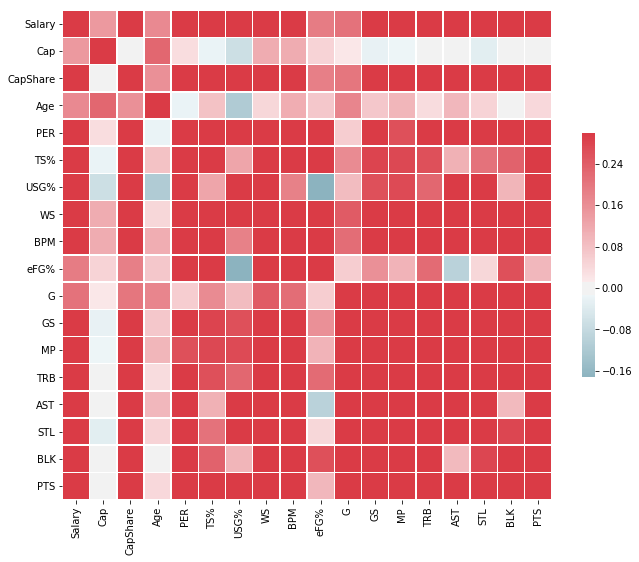

In [56]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(NBA_info3.corr(), cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

There appears to be high correlation among most of the chosen variables

In [57]:
corr = NBA_info3.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

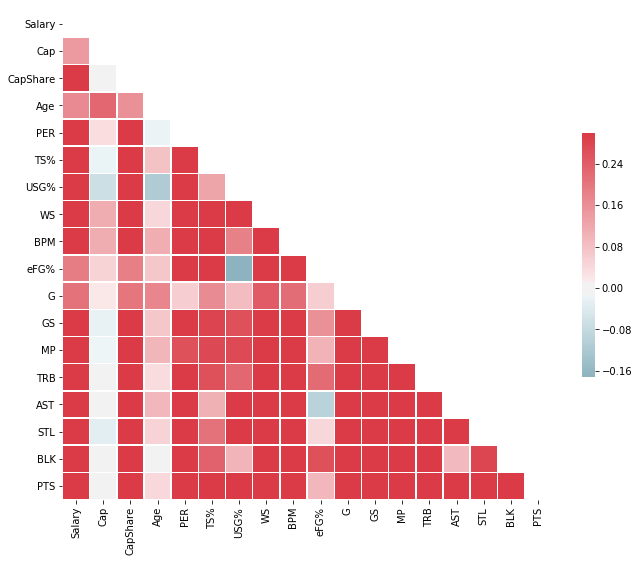

In [58]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

***

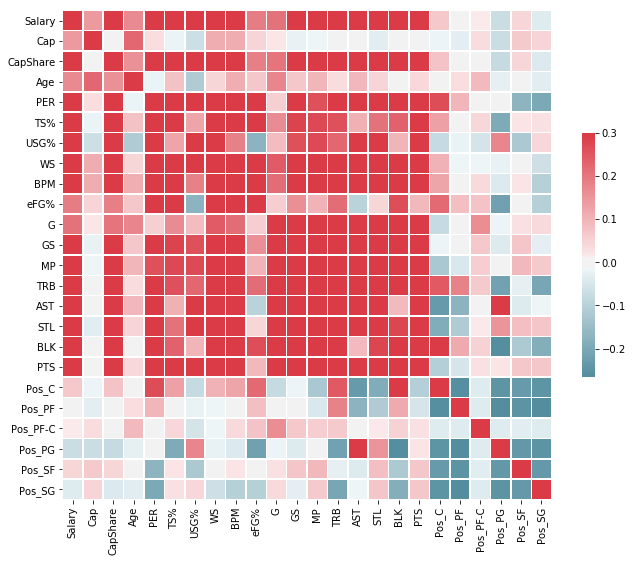

In [59]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(dumdf.corr(), cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [60]:
NBA_col = dumdf[['Salary','Pos_C', 'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG', 'Age', 'PER', 'TS%', 'WS','USG%', 'G','GS', 'MP', 'TRB', 'AST', 'STL', 'BLK', 'PTS']]
NBA_pair = dumdf[['Salary','Pos', 'Age','G','GS', 'MP', 'TRB', 'AST', 'STL', 'BLK', 'PTS','PER', 'WS']]
NBA_play_info = dumdf[['Salary','Pos', 'Age','G','GS', 'MP']]
NBA_stats_info = dumdf[['Salary','PER', 'WS', 'TRB', 'AST', 'STL', 'BLK', 'PTS']]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

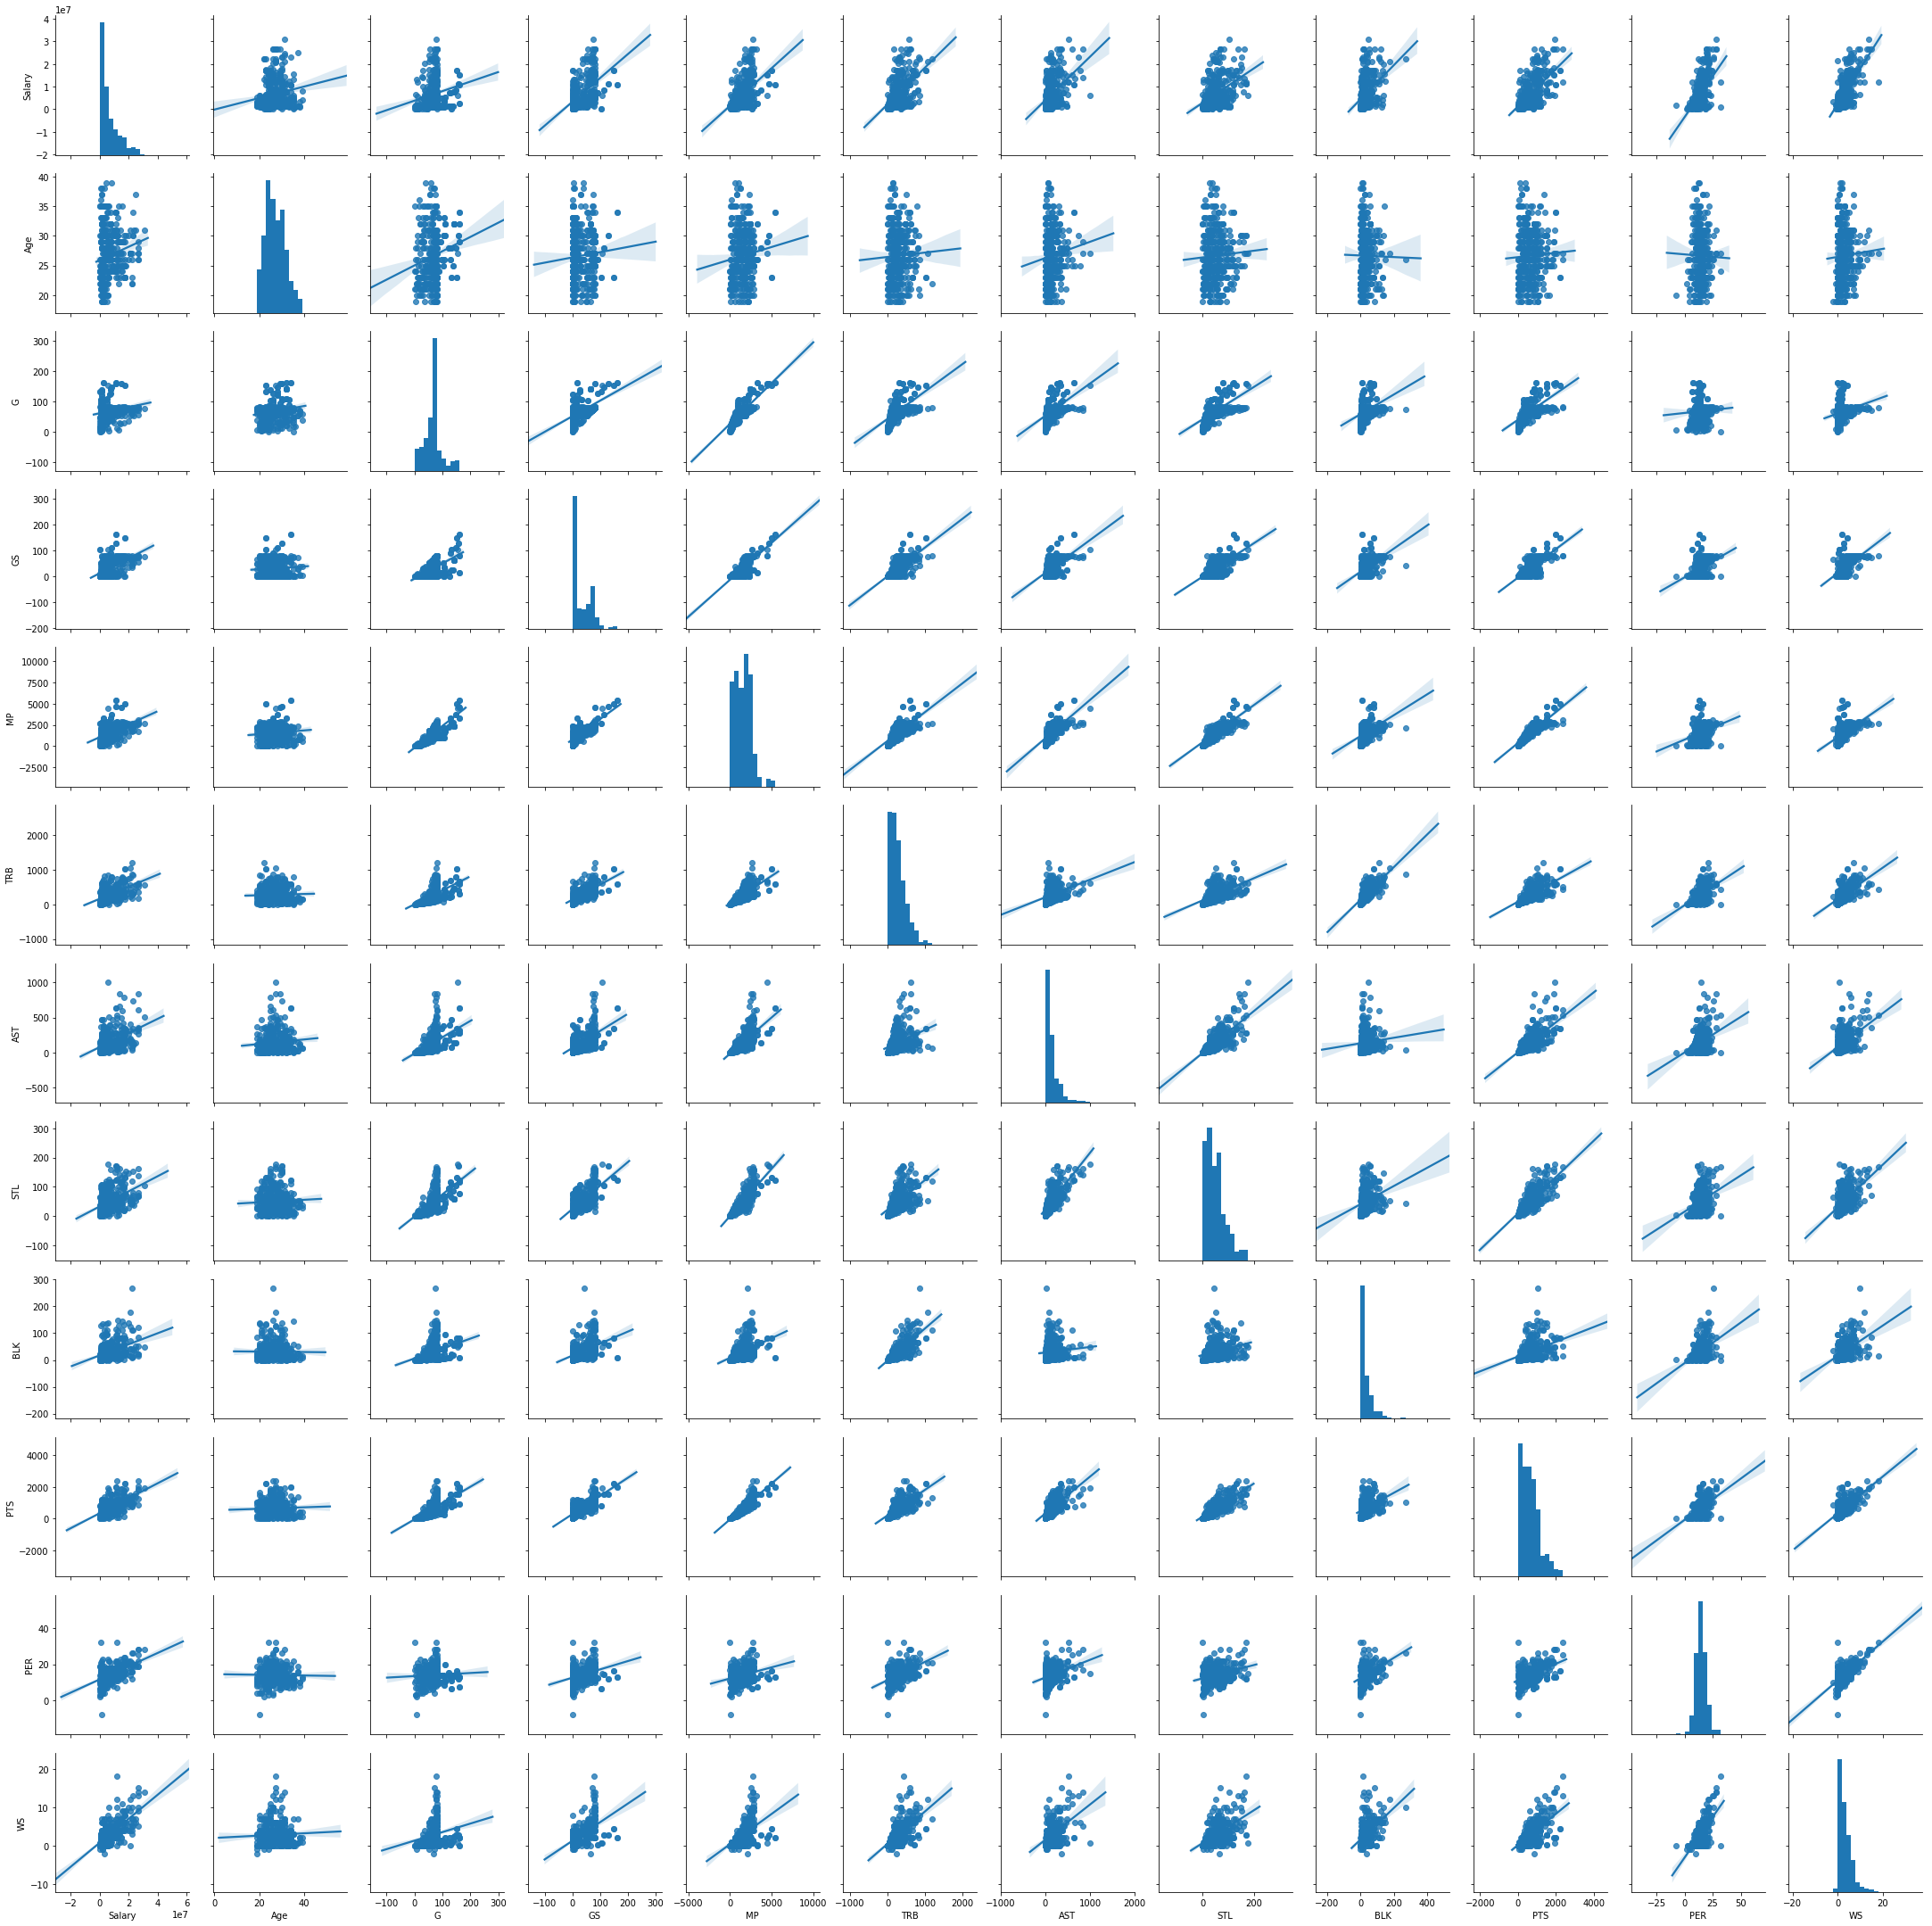

In [61]:
plt.figure()

sns.pairplot(NBA_pair, kind='reg')

The pairplot is too large to do a proper analysis and comparison, therefore I broke the pairplot into 2 groups, player info and NBA stats info.

<Figure size 432x288 with 0 Axes>

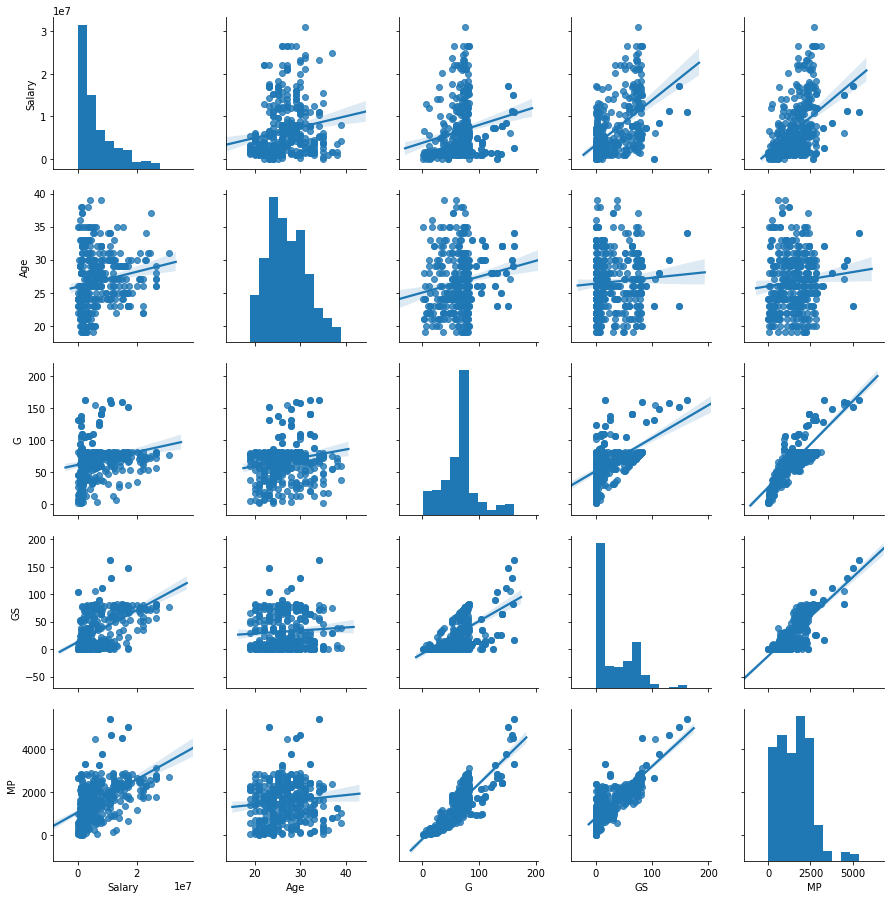

In [62]:
plt.figure()

sns.pairplot(NBA_play_info, kind='reg')

<Figure size 432x288 with 0 Axes>

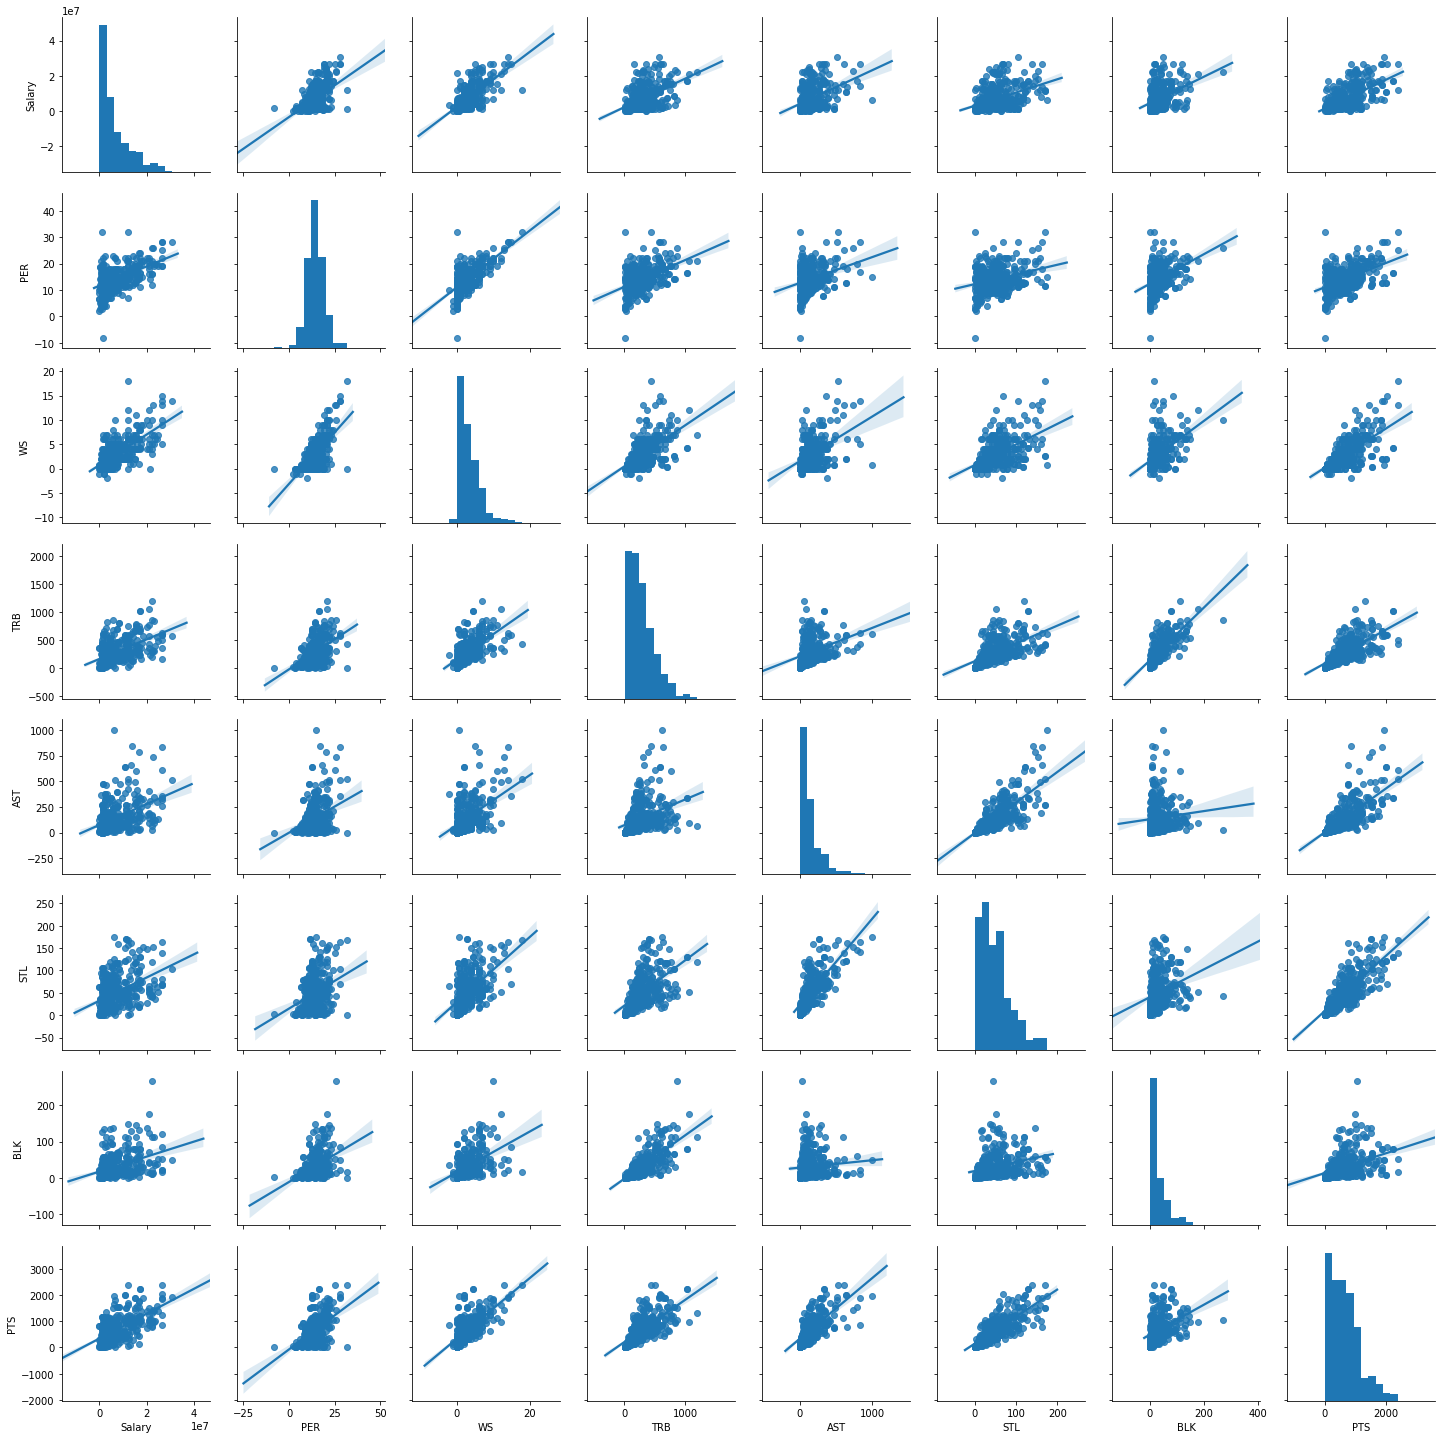

In [63]:
plt.figure()

sns.pairplot(NBA_stats_info, kind='reg')

For each of the scatter plots there appears to be a strong positive relationship between each of the variables.

### NBA Age vs. Salary

<Figure size 432x288 with 0 Axes>

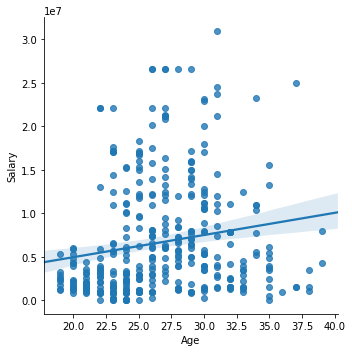

In [64]:
plt.figure()
sns.lmplot('Age', 'Salary', data=NBA_info3, fit_reg=True)

The scatter plot seems to show a positive relationship between Age and Salary. In addition most players are between the ages of 20 and 35, and the highest paid players are between 25 and 30 years old.

### NBA Age Distribution

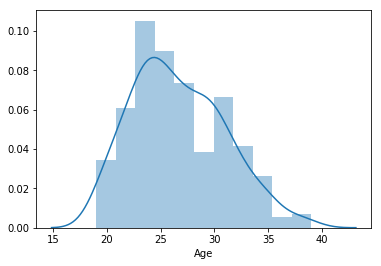

In [65]:
plt.figure()
sns.distplot(NBA_info3['Age'])

This histogram confirms that the majority of players are between the age 25 and 30

### Salary vs PER

<Figure size 432x288 with 0 Axes>

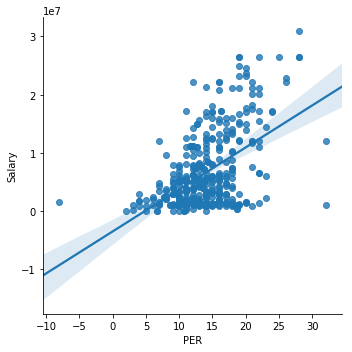

In [66]:
plt.figure()
sns.lmplot('PER', 'Salary', data=NBA_info3, fit_reg=True)

There is also strong positive correlation between Salary and PER in addition to a clustering of the data. 

### NBA Salary Distribution

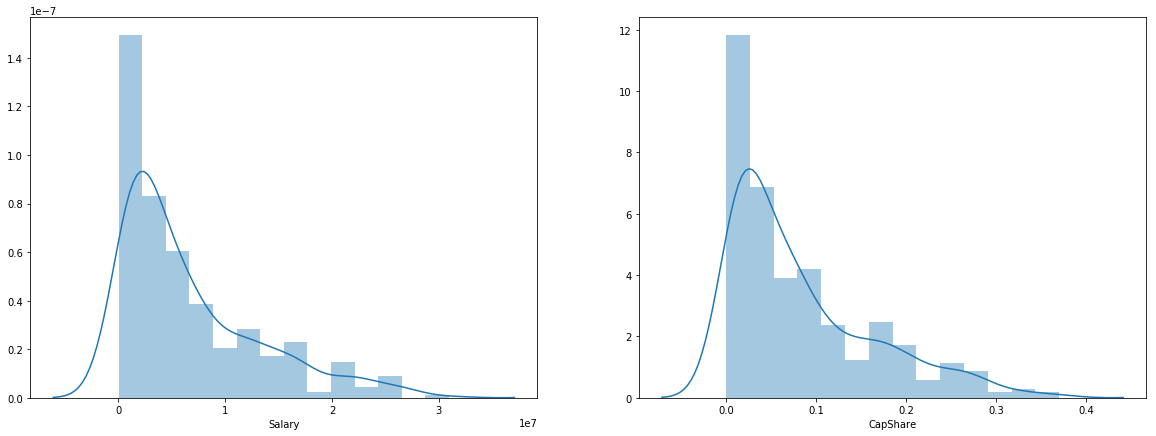

In [67]:
f, axes = plt.subplots(1, 2,figsize=(20, 7))
sns.distplot(NBA_info3['Salary'], ax=axes[0])
sns.distplot(NBA_info3['CapShare'], ax=axes[1])

It appears that the player salaries and CapShare are skewed right, indicating that majorit of players are paid below the median and recieve a share of the team cap that is below the median.

#### Cap EDA

In [68]:
cap_16.shape

(30, 2)

In [69]:
cap_16.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, Cleveland Cavaliers to Portland Trailblazers
Data columns (total 2 columns):
Year    30 non-null int64
Cap     30 non-null int64
dtypes: int64(2)
memory usage: 720.0+ bytes


In [70]:
print(cap_16.describe())

         Year           Cap
count    30.0  3.000000e+01
mean   2016.0  7.926179e+07
std       0.0  1.111011e+07
min    2016.0  6.248886e+07
25%    2016.0  7.231516e+07
50%    2016.0  7.593067e+07
75%    2016.0  8.657848e+07
max    2016.0  1.081260e+08


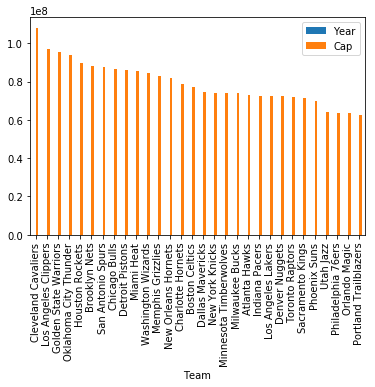

In [71]:
cap_16.plot.bar()

***

## Which players do teams spend the most of their salary cap on?

hypothesis: top_share contains the players with the highest cap share for each team, as well as the highest paid player for each team

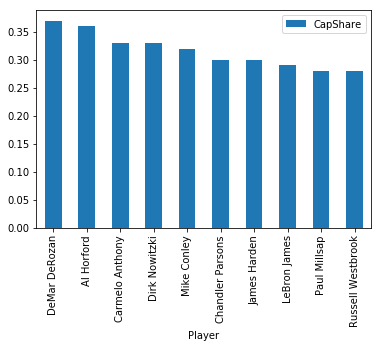

In [72]:
# Highest paid player for each team
NBA_share = NBA_info3['CapShare'].to_frame().sort_values('CapShare', ascending=False).nlargest(10, 'CapShare')
NBA_share.groupby('Player').mean().sort_values('CapShare', ascending=False).plot.bar()

***

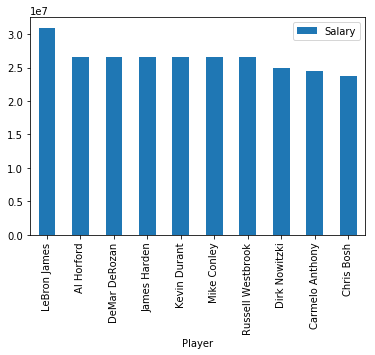

In [73]:
NBA_pay = NBA_info3['Salary'].to_frame().sort_values('Salary', ascending=False).nlargest(10, 'Salary')
NBA_pay.groupby('Player').mean().sort_values('Salary', ascending=False).plot.bar()

In [74]:
# common values between dataframes
common = pd.merge(NBA_pay, NBA_share, on=['Player'], how='inner')
common.shape, common

((8, 2),                      Salary  CapShare
 Player                               
 LeBron James       30963450      0.29
 Al Horford         26540100      0.36
 DeMar DeRozan      26540100      0.37
 James Harden       26540100      0.30
 Mike Conley        26540100      0.32
 Russell Westbrook  26540100      0.28
 Dirk Nowitzki      25000000      0.33
 Carmelo Anthony    24559380      0.33)

8 of the 10 players with the highest cap share percentage are also in the top ten paid players in the league

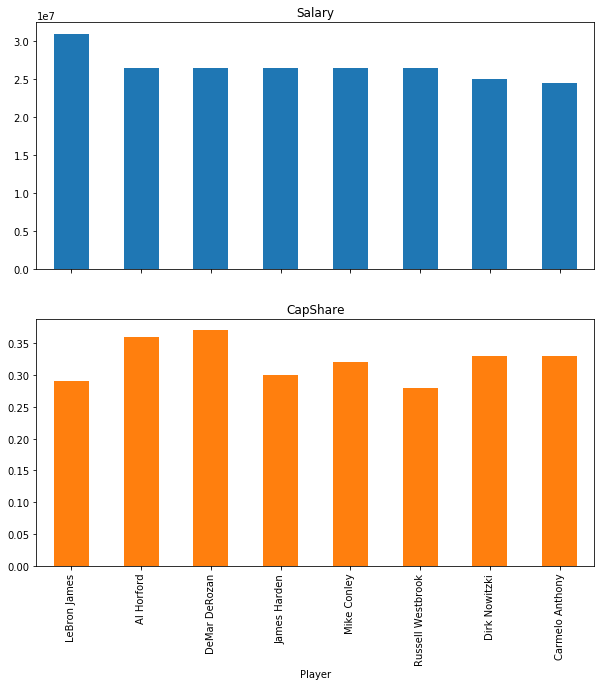

In [75]:
axes = common.plot.bar(rot=90, subplots=True, legend = False, figsize=(10,10))

The Cleveland Cavaliers have the largest salary and the highest paid player in the league. 

***

***

# Linear Regression

- H_0 = A high PER will lead to a high salary
- H_A = A high PER does not lead to a high salary

In [76]:
dumdf = dumdf.drop('Pos', axis=1)

In [77]:
import statsmodels.api as sm

X = dumdf[['Age','PER','WS', 'TS%', 'USG%', 'Pos_C', 'Pos_PF', 
           'Pos_PG', 'Pos_SF', 'Pos_SG','AST', 'STL', 'BLK', 'PTS']]
y = dumdf[['Salary']]

In [78]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     106.5
Date:                Wed, 08 May 2019   Prob (F-statistic):          1.82e-122
Time:                        19:03:01   Log-Likelihood:                -6618.3
No. Observations:                 397   AIC:                         1.326e+04
Df Residuals:                     383   BIC:                         1.332e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age         1.739e+05   4.52e+04      3.850      0.0

- The p-value for each term tests the null hypothesis that the coefficient has no effect. A low p-value(<0.05) indicates a rejection of the null hypothesis, meaning that coefficient has an effect.
- In this model everything but PER, TS% and BLK have low p-values indicating they have an effect.

In [79]:
import statsmodels.api as sm

X = dumdf[['Age','PER','WS', 'TS%', 'USG%', 'AST', 'STL', 'BLK', 'PTS']]
y = dumdf[['Salary']]

In [80]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     158.1
Date:                Wed, 08 May 2019   Prob (F-statistic):          6.24e-124
Time:                        19:03:01   Log-Likelihood:                -6627.6
No. Observations:                 397   AIC:                         1.327e+04
Df Residuals:                     388   BIC:                         1.331e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age         9.052e+04   3.11e+04      2.906      0.0

### Salary and Player Efficiency Rating

In [81]:
import statsmodels.api as sm

X = dumdf['PER']
y = dumdf[['Salary']]

In [82]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     669.7
Date:                Wed, 08 May 2019   Prob (F-statistic):           3.76e-87
Time:                        19:03:01   Log-Likelihood:                -6736.9
No. Observations:                 397   AIC:                         1.348e+04
Df Residuals:                     396   BIC:                         1.348e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PER         4.984e+05   1.93e+04     25.879      0.0

In conclusion PER is not a good indicator for expected salary. The R^2 value is lower for PER and salary then for WS and Salary. While each have low

***

### Salary and Win Share

In [84]:
import statsmodels.api as sm

X = dumdf['WS']
y = dumdf[['Salary']]

In [85]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1033.
Date:                Wed, 08 May 2019   Prob (F-statistic):          2.13e-112
Time:                        19:03:01   Log-Likelihood:                -6678.7
No. Observations:                 397   AIC:                         1.336e+04
Df Residuals:                     396   BIC:                         1.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
WS          1.953e+06   6.08e+04     32.138      0.0

***

In conclusion 